In [8]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import os
os.getcwd()

'C:\\Users\\mandapm'

In [9]:
#changing working directory to point to file location
os.chdir('C:\\Users\\mandapm\\Documents\\CS Class\\assgn4')

In [10]:
def kernel(a,b,p,fn,beta):
    K = np.zeros((len(b),len(a)))
    if fn ==1: # squared exponential
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        K = np.exp(-.5 * (1/p**2) * sqdist)
        K = K.T
    else:
        for m in range(len(b)):
            K[m] = np.exp(-(np.absolute(a-b[m]))/(p)).reshape(-1,)
    return K

In [11]:
def predict(train,test,beta,p,fn):
    E_y = np.zeros(len(test[:,0]))
    K1_train = kernel(train[:,0].reshape(-1,1),train[:,0].reshape(-1,1),p,fn,beta)
    C1_train = K1_train + ((np.eye(len(train[:,0])))/beta)
    a = np.dot(np.linalg.inv(C1_train),train[:,1]) 
    K1_test = kernel(test[:,0].reshape(-1,1),train[:,0].reshape(-1,1),p,fn,beta)
    E_y = np.dot(a,K1_test)
    pred_y = (E_y- np.min(E_y))/(np.max(E_y)-np.min(E_y))
    return pred_y


In [12]:
def CV(data,cv,beta,fn,start,stop,num=100):
    n = len(data[:,0])
    ntrain = int((cv-1)*n/cv)
    ntest = int(n/cv)
    Sq_error = np.zeros((cv,ntest))
    v=0
    MSE = np.zeros(num)
    values =  np.linspace(start, stop, num=num) # range for sigma
    for sigma in values:
        for c in range(cv):
            mask = range ((ntest*c),(ntest*(c+1)),1)
            test = data[mask] 
            train = data[[i for i in range(ntrain+ntest) if not i in mask]]
            pred_y = predict(train,test,beta,sigma,fn)
            Sq_error[c,:] = (pred_y - test[:,1])**2
        MSE[v] = np.mean(Sq_error)
        v=v+1
    print('Best sigma = ', np.around(values[np.argmin(MSE)],decimals=3))   
    return np.around(values[np.argmin(MSE)],decimals=3) 
    

Squared Exponential
Best sigma =  0.193
Exponential
Best sigma =  0.2


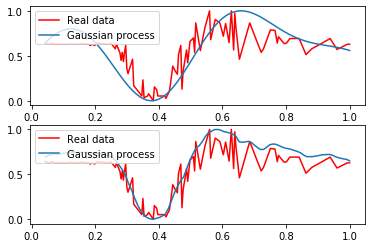

In [13]:
def problem1():
    data = np.loadtxt('crash.txt')
    std_dev = (20 - np.min(data[:,1]))/(np.max(data[:,1])-np.min(data[:,1]))
    beta = 1/(std_dev**2)
    data[:,0] = data[:,0]/np.max(data[:,0])
    data[:,1] = (data[:,1]- np.min(data[:,1]))/(np.max(data[:,1])-np.min(data[:,1]))
    print('Squared Exponential')
    sigma1=CV(data,5,beta,1,start = 0.1,stop = 0.2)
    print('Exponential')
    sigma2=CV(data,5,beta,2,start = 0.1,stop = 0.2)
    sample = np.zeros((100,2))
    sample[:,0] = np.linspace(np.min(data[:,0]), 1, num=100)
    pred_y1 = predict(data,sample,beta,sigma1,1)
    plt.subplot(2, 1, 1)
    plt.plot(data[:,0],data[:,1], color = 'red')
    plt.plot(sample[:,0],pred_y1)
    plt.legend(('Real data', 'Gaussian process'),
           loc='upper left', shadow=False)
    plt.subplot(2, 1, 2)
    pred_y2 = predict(data,sample,beta,sigma2,2)
    plt.plot(data[:,0],data[:,1], color = 'red')
    plt.plot(sample[:,0],pred_y2,label = 'sigma')
    plt.legend(('Real data', 'Gaussian process'),
           loc='upper left', shadow=False)
    
problem1()

In [14]:
def plot_image(pixels: np.array):
    plt.imshow(pixels.reshape((28, 28)), cmap='winter')
    plt.show()  


In [15]:
def initialize(init,X,k,Y):
    mu = np.random.rand(k,784)
    if init ==1: # ten random data points 
        sequence = [i for i in range(10000)]
        subset = random.sample(sequence, 10)
        mu_init = X[subset,:]
    elif init ==2: #ten points using k-means++
        sequence = [i for i in range(10000)]
        subset = random.sample(sequence, 1)
        for i in range(k):
            mu[i]=X[subset,:]
            dist = np.sum((X-mu[i])**2,axis=1)
            i = np.argsort(np.max(dist.reshape(-1,1),axis=1))[-i]
            subset = i
        mu_init = mu
    else: # datapoint chosen from each labeled class
        subset = np.zeros((k,784))
        for l in range(k):
            ind = np.random.randint(low=0, high=500, size=1)
            selected_y = X[Y[:,0]==l]
            subset[l] = selected_y[ind]
        mu_init = subset
    return mu_init

In [16]:
def kmeans_assignment(mu,X,k):
    z = np.zeros((len(X[:,0]),k))
    for i in range(len(X[:,0])):
        x1 = np.array(X[i],dtype = 'int')
        dist = np.zeros(k)
        for j in range(k):
            x2 = np.array(mu[j])
            dist[j]= np.sqrt(np.sum((x1-x2)**2))
        z[i,np.argmin(dist)]=1
    return z

def kmeans_meanupdate(z,k,X):
    N = np.sum(z.T,axis = 1).reshape(1,k)
    mu_new = np.zeros((k,784))
    a = np.dot(z.T,X)
    for l in range(k):
        mu_new[l] = a[l]/N[0,l]
    return mu_new 

def kmeans_iterations(mu,X,k,i=0,z=0):
    if i == 0:
        z = kmeans_assignment(mu,X,k)
        mu = kmeans_meanupdate(z,k,X)
    z_new = kmeans_assignment(mu,X,k)
    mu_new = np.around(kmeans_meanupdate(z_new,k,X),decimals =1)
    print('.', end ="")
    if np.array_equal(z_new, z):
        if np.array_equal(mu_new,mu):
            print('\n',i,' iterations, ',end = '')
            J=0
            fig, ax = plt.subplots(int(k/int(k/2)),int(k/2))
            for i, ax in enumerate(ax.flatten()):
                 ind = z_new[:,i]==1
                 J += np.sum((X[ind]-mu_new[i])**2)
                 X_K = X[ind]
                 plottable_image = np.reshape(X_K[9,0:784], (28, 28))
                 ax.imshow(plottable_image, cmap='winter')
            print('J = ',J)
            plt.show()             
    else:
        kmeans_iterations(mu=mu_new,X=X,k=k,i=i+1,z=z_new)
    return mu_new


Random Initialization
.....................................................................................
 84  iterations, J =  25321396224.540005


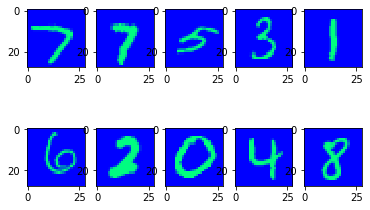

k-means++ initialization


C:\Users\mandapm\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [22]:
def problem2():
    test_images_file = open('t10k-images-idx3-ubyte','rb')
    test_images = test_images_file.read()
    test_images_file.close()
        
    test_labels_file = open('t10k-labels-idx1-ubyte','rb')
    test_labels = test_labels_file.read()
    test_labels_file.close()

    test_images = bytearray(test_images)
    test_labels = bytearray(test_labels)
    
    test_images = test_images[16:]
    test_images = np.array(test_images)
    X = test_images.reshape(10000,784) 
    X = np.array(X,dtype = 'int').reshape(10000,784)
    
    test_labels = test_labels[8:]
    test_labels = np.array(test_labels)
    Y = test_labels.reshape(10000,1)
    
    print('Random Initialization')
    mu_init1 = initialize(init = 1,X=X,k=10,Y=Y) 
    kmeans_iterations(mu = mu_init1,X=X,k=10)
    print('k-means++ initialization')
    mu_init2 =  initialize(init = 2,X=X,k=10,Y=Y)
    kmeans_iterations(mu = mu_init2,X=X,k=10)
    print('Cheating Initialization')
    mu_init3 = initialize(init = 3,X=X,k=10,Y=Y)
    kmeans_iterations(mu = mu_init3,X=X,k=10)
    print('For 3 clusters and K++ initialization')
    mu_init4 = initialize(init = 2,X=X,k=3,Y=Y)
    mu_final4 = kmeans_iterations(mu = mu_init4,X=X,k=3)
    fig, ax = plt.subplots(1,3)
    for i, ax in enumerate(ax.flatten()):
                 plottable_image = np.reshape(mu_final4[i,0:784], (28, 28))
                 ax.imshow(plottable_image, cmap='winter')
    plt.show()
    
problem2()

In [19]:
def actual_output(step):
    x = np.zeros(step)
    z = np.zeros(step)
    for j in range(int(step/5)):
        z[5*j:5*(j+1)] = np.array(random.choices(population=[1,0],weights=[0.3,0.7],k=1))
    z[0] = 0     # initialized with fair
    for i in range(step):
        if z[i] == 1: #means loaded
            x[i] = np.array(random.choices(population=[1,2,3,4,5,6],weights=[0.1, 0.1, 0.1,0.1,0.1,0.5],k=1))
        else: # means fair
            x[i] = np.array(random.choices(population=[1,2,3,4,5,6],weights=[0.167, 0.167, 0.167,0.167,0.167,0.166],k=1))
    return z,x

In [20]:
def forward(step,x):
    e_F = np.ones(6)/6
    e_L = np.ones(6)/6
    e_L[0:5] = 0.1
    e_L[5] = 0.5
    p_F = np.zeros(step)
    p_L = np.zeros(step)
    for i in range(step):
        if i == 0:
            p_F[i] = 0.7
            p_L[i] = 0.3
        else:
            j = int(x[i])
            p_F_temp = ((p_F[i-1]*0.95)+(p_L[i-1]*0.10))*e_F[j-1]
            p_L_temp = ((p_F[i-1]*0.05)+(p_L[i-1]*0.90))*e_L[j-1]
            p_F[i] = p_F_temp/(p_F_temp+p_L_temp)
            p_L[i] = p_L_temp/(p_F_temp+p_L_temp)
    return  p_F,p_L

def backward(step,p_F,p_L,x):
    up_F = np.zeros(step)
    up_L = np.zeros(step)
    up_F[step-1] = p_F[step-1]
    up_L[step-1] = p_L[step-1]
    e_F = np.ones(6)/6
    e_L = np.ones(6)/6
    e_L[0:5] = 0.1
    e_L[5] = 0.5
    for i in range(step-2,-1,-1):
        j = int(x[i+1])
        up_F_temp = (0.95*e_F[j-1]*up_F[i+1])+(0.10*e_L[j-1]*up_L[i+1])
        up_L_temp = (0.05*e_F[j-1]*up_F[i+1])+(0.90*e_L[j-1]*up_L[i+1])
        up_F[i] = up_F_temp/(up_F_temp+up_L_temp)
        up_L[i] = up_L_temp/(up_F_temp+up_L_temp)
    return up_F,up_L

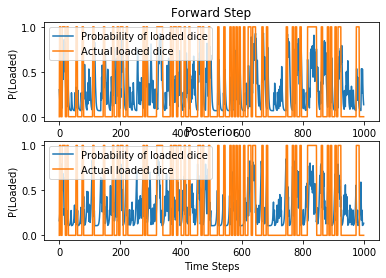

In [21]:
def problem3():
    step = 1000
    z,x = actual_output(step)
    i = range(step)
    plt.plot(i,z)
    p_F,p_L = forward(step,x)
    plt.subplot(2, 1, 1)
    plt.title('Forward Step')
    plt.plot(i,p_L)
    plt.plot(i,z)
    plt.xlabel('Time Steps')
    plt.ylabel('P(Loaded)')
    plt.legend(('Probability of loaded dice', 'Actual loaded dice'),
           loc='upper left', shadow=False)
    up_F,up_L= backward(step,p_F,p_L,x)
    plt.subplot(2, 1, 2)
    plt.title('Posterior')
    plt.plot(i,up_L,label = 'Probability of loaded dice')
    plt.plot(i,z,label = 'Actual loaded dice')
    plt.xlabel('Time Steps')
    plt.ylabel('P(Loaded)')
    plt.legend(('Probability of loaded dice', 'Actual loaded dice'),
           loc='upper left', shadow=False)
    plt.show()
    
problem3()